# Reconhecimento de Dígitos
## 1. Preparação do Ambiente

In [162]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [163]:
TEST_DATA_PATH = ('dados/test.csv')
TRAIN_DATA_PATH = ('dados/train.csv')
data_test_df = pd.read_csv(TEST_DATA_PATH, sep=';')
data_train_df = pd.read_csv(TRAIN_DATA_PATH, sep=';')

## 2. Redução da dimensão das amostras
### 2.1. Intensidade da imagem

### 2.2. Simetria da imagem

In [166]:
def calcular_intensidade_e_simetria(row):
    # Assume row[1:] contains pixel values starting from pixel0 to the last pixel.
    pixelx = row[1:].values.reshape(28, 28)
    
    intensidade = pixelx.sum() / 255.0

    simetria_vertical = np.sum(np.abs(pixelx[:, :14] - pixelx[:, ::-1][:, :14])) / 255.0
    simetria_horizontal = np.sum(np.abs(pixelx[:14, :] - pixelx[::-1, :][:14, :])) / 255.0
    simetria_completa = simetria_vertical + simetria_horizontal
    
    return pd.Series({'intensidade': intensidade, 'simetria': simetria_completa})

# Apply the function along the rows (axis=1) and assign the results directly to the respective columns.
data_train_df[['intensidade', 'simetria']] = data_train_df.apply(calcular_intensidade_e_simetria, axis=1)
data_test_df[['intensidade', 'simetria']] = data_test_df.apply(calcular_intensidade_e_simetria, axis=1)


In [167]:
colunas_relevantes = ['label', 'intensidade', 'simetria']
TEST_REDU_DATA_PATH = ('dados/test_redu.csv')
TRAIN_REDU_DATA_PATH = ('dados/train_redu.csv')

data_test_df[colunas_relevantes].to_csv('dados/test_redu.csv', index=False)
data_train_df[colunas_relevantes].to_csv('dados/train_redu.csv', index=False)

In [168]:
data_test_redu_df = pd.read_csv(TEST_REDU_DATA_PATH)
data_train_redu_df = pd.read_csv(TRAIN_REDU_DATA_PATH)

In [169]:
data_test_redu_df

,label,intensidade,simetria
0,0,147.933333,130.470588
1,0,131.054902,122.721569
2,0,134.890196,151.725490
3,0,139.976471,133.921569
4,0,129.580392,130.274510
...,...,...,...
1110,5,96.121569,139.521569
1111,5,98.439216,130.729412
1112,5,95.141176,122.227451
1113,5,106.882353,128.007843


## 3. Classificação dos dígitos 1x5
### 3.1. Filtragem dos dados

In [170]:
data_test_redu_filtered_df = data_test_redu_df[(data_test_redu_df['label'] == 1) | (data_test_redu_df['label'] == 5)]
data_train_redu_filtered_df = data_train_redu_df[(data_train_redu_df['label'] == 1) | (data_train_redu_df['label'] == 5)]

In [171]:
data_train_redu_filtered_df['label'].unique()

array([1, 5], dtype=int64)

### 3.2. Plotagem de dados de train1x5

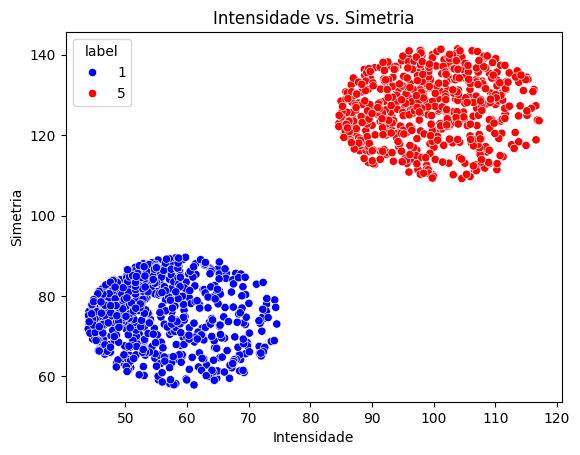

In [172]:
def plotagem_grafico(data_train_redu_filtered_df):
    sns.scatterplot(data=data_train_redu_filtered_df, x='intensidade', y='simetria', hue='label', palette={1: 'blue', 5: 'red'})
    plt.title('Intensidade vs. Simetria')
    plt.xlabel('Intensidade')
    plt.ylabel('Simetria')

plotagem_grafico(data_train_redu_filtered_df)

In [173]:
data_train_redu_filtered_df

,label,intensidade,simetria
425,1,44.701961,69.270588
426,1,59.850980,83.443137
427,1,48.552941,79.043137
428,1,69.435294,72.878431
429,1,51.541176,84.611765
...,...,...,...
2181,5,105.686275,133.890196
2182,5,113.050980,116.698039
2183,5,110.725490,133.019608
2184,5,99.305882,132.133333


In [180]:
from modelos_lineares.perceptron import *

X_train = data_train_redu_filtered_df.iloc[:, 1:].values
for i in range(np.shape(X_train)[1]):
    X_train[:,i] = (X_train[:,i] - np.mean(X_train[:,i]))/np.std(X_train[:,i])
        
y_train = data_train_redu_filtered_df.iloc[:, 0].values
y_train = np.where(y_train == 1, 1, -1)

perceptron = Perceptron(taxa_aprendizado=0.01, n_iteracoes=200)

perceptron.fit(X_train, y_train)

(1184, 2)
(1184,)


100%|██████████| 200/200 [00:01<00:00, 114.56it/s]


C:\Users\gabri\AppData\Local\Temp\ipykernel_30760\3233284390.py:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


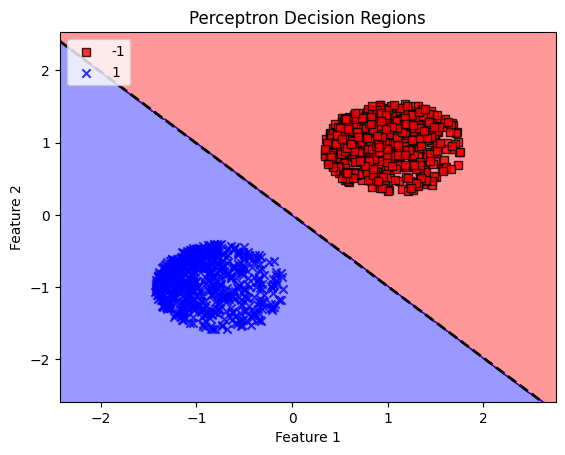

In [181]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Configura marcadores e colormap
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Cria o grid de plotagem
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # Previsão para cada ponto no grid
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Plota a região de decisão
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    
    # Plota amostras de classe
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl,
                    edgecolor='black')
        
    # Desenha a linha de decisão
    weights = classifier.weight
    a = -weights[1] / weights[2]  # Inclinação da linha
    b = -weights[0] / weights[2]  # Interceptação y da linha
    decision_boundary = np.array([x1_min, x1_max])
    plt.plot(decision_boundary, a * decision_boundary + b, "k--", linewidth=2)
    
    # Define os limites do gráfico
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Perceptron Decision Regions')
    plt.legend(loc='upper left')

# Agora você pode chamar a função plot_decision_regions como você já fez:
plot_decision_regions(X_train, y_train, classifier=perceptron)
plt.show()